# Lacrosse Predictors

Every year, in early May, the regular season winds down for college lacrosse and the playoffs begin. Unlike NCAA basketball and March Madness – where 66 teams are invited – only 18 teams are invited to the national tournament. For the 70 Division I teams competing for those spots, there are two ways to be selected. The first way is simple, secure an automatic qualification by winning your conference’s playoff tournament. There are ten conferences, leaving eight spots for other teams. These spots, known as “at-large” selections are up to the National Selection Committee to hand out. The committee utilizes the following criteria to select and seed teams:

> - Strength of schedule index.
> - Results of the RPI.
>   - Record against ranked teams 1-5; 6-10; 11-15; 16-20; 21+
>   -  Average RPI win (average RPI of all wins)
>   - Average RPI loss (average RPI of all losses)
> - Head-to-head competition:
>   - Results versus common opponents.
>   - Significant wins and losses (wins against teams ranked higher in the RPI and losses against teams ranked lower in the RPI).
>   - Locations of contests. 
> - Input from the regional advisory committee (comprised of lacrosse coaches from all AQ conferences). 

These criteria seem to place serios significance on this “RPI” ranking, but what even is it?

RPI, or rating percentage index, is a ranking of sports teams that aims to combine wins, losses, and strength of schedule. For any particular lacrosse team, it is calculated as:

- 25% the team's winning percentage
- 50% the team's opponents' average winning percentage
- 25% the team's opponents' opponents' winning percentages

The selection committee has traditionally used the RPI as a factor in its decisions for a variety of factors. For one thing, it is relatively easy to calculate. You do not need any advanced data or subjective metrics. All you need is teams wins and losses. Moreover, for a sport like college lacrosse, where each team only plays a small subset of the all the other teams, RPI does a good job considering teams that had harder and easier schedules. On top of that, RPI does typically align well with the “eye-test,” or how good you think a team is just by watching it. For those and other reasons, RPI has become an integral part of the selection process for the national college lacrosse tournament.

There are, however, several aspects of RPI to complain about. First off, it does not account for factors like margin of victory and home field advantage. Those are factors are known to important when predicting future outcomes. Additionally, not all conferences are equally competitive, so RPI can artificially inflate RPIs of “good” conferences and deflate RPIs of “bad” conferences.

With that in mind, I will be looking into the question of whether RPI is the best statistic to use for predicting outcomes of college lacrosse game, or if there is a better predictor out there that maybe the selection committee should be using. 

I will be pursuing two main avenues to try and find a better predictor. First, I will look at the ELO ranking system. ELO is rating system originally designed for ranking chess players, which you can read more about [here](https://en.wikipedia.org/wiki/Elo_rating_system). There are number of nuances to apply the ELO system to lacrosse, but those have mostly been taken care of by the lacrosse analytics site Lacrosse Reference. A detailed explanation of their lacrosse ELO system can be found [here](https://lacrossereference.com/2017/04/25/introducing-elo-college-lacrosse/), and I will just use their model for my comparison.

Second, I will try to improve RPI itself using gradient decent to find better weights to apply to the three statistics it is based off. 25%, 50%, and 25% were originally arbitrarily chosen as “nice” values that seemed right. It begs to reason then that by tweaking those values with gradient decent we could create an RPI like stat that is a better predictor of the outcome of lacrosse games.

To begin the analysis, there are several datasets I need to create. I first need a dataset of all the college lacrosse games that have been played this season. I can only look at the current season because Lacrosse Reference only has the current season’s ELO rankings publicly available. Therefore, I will not be able to look at predictiveness for post-season games, as the post-season has not completed yet as I am writing this. That is not a problem though, since the regular season has completed, and is a larger dataset to analyze anyway.

To get the game data, I will be using the [daily scoreboard](https://stats.ncaa.org/contests/scoreboards?utf8=%E2%9C%93&sport_code=MLA&academic_year=&division=&game_date=&commit=Submit) on the NCAA Statistics website. The scoreboard has information on all the games played on a given day, including who played and who won. I was not able to find a public API, so to get the data I scraped day by day for every day of the lacrosse season. As I collect the data I am putting it in two dataframes. One dataframe serves as a schedule, saving the winner of each game, as well as which team was home and away. The other dataframe stores each game twice, once for each team. This will make it easier later to select the games a team played or the games where teams played against them, for instance.


In [1]:
import requests as reqs
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# helper function for removing parenthesis from the end of strings
def remove_record(str):
  try:
    return re.match(r'^(.*) \(', str).group(1)
  except AttributeError:
    return str

# some of the sites I am scrapping from will not respond unless the user agent string is set
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

# These are the names that need to be replaced so that all the data sources have standard 
# names and I do not run into issues with some teams being called different things in
# different dataframes.
team_names = {
  'Army West Point': 'Army',
  'UAlbany': 'Albany', 
  'Albany (NY)': 'Albany',
  'Boston U.': 'Boston U',
  'Boston': 'Boston U',
  'Cleveland St.': 'Cleveland State',
  'Detroit Mercy': 'Detroit',
  'Loyola Maryland': 'Loyola',
  'Massachusetts': 'UMass',
  "Mount St. Mary’s": 'Mount St. Mary\'s',
  "Mount St Marys": 'Mount St. Mary\'s',
  'Ohio St.': 'Ohio State',
  'Penn St.': 'Penn State',
  'St. John\'s (NY)': 'St. John\'s',
  "St. John’s": "St. John\'s",
  'UMass Lowell': 'UMass-Lowell',
  'Saint Joseph`s': 'Saint Joseph\'s',
  'Saint Joseph’s': 'Saint Joseph\'s'
}


season_dates = pd.date_range('2022-01-29', datetime.now())

In [ ]:
# empty dataframes to store data in
df_games = pd.DataFrame()
df_schedule = pd.DataFrame()

for date in season_dates:
  try: 
    # can just change the month and day parameters in the url to get a different day's games
    url = f'https://stats.ncaa.org/season_divisions/17822/scoreboards?utf8=%E2%9C%93&season_division_id=&game_date={date.month}%2F{date.day}%2F2022&conference_id=0&tournament_id=&commit=Submit'

    # make request and turn into dataframe
    req = reqs.get(url, headers=headers)
    games_table = pd.read_html(req.content)[0]

    # for each game in the games table, we need to 
    # further parse out the team names and other info.
    # each game is represented by 5 rows in the html table
    for i in range(0, len(games_table), 5):
      try:
        # grab the 5 rows that make up this game
        game = games_table.loc[i:i+5]

        # the team names are followed by the record, but we just
        # want to store the name with no record following it
        team1 = remove_record(game.loc[i, 'Teams.1'])
        team2 = remove_record(game.loc[i+3, 'Teams'])

        # some teams have a number ranking before the name
        # we are not interested in that so it is removed
        team1 = re.sub(r'^#\d ', '', team1)
        team2 = re.sub(r'^#\d ', '', team2)

        # read in the scores so we can tell who won
        team1_score = int(game.loc[i, 'Score.1'])
        team2_score = int(game.loc[i + 3, 'Teams.1'])

        # let win = 1 and loss = 0 to make manipulation easy later
        team1_outcome = 1 if team1_score > team2_score else 0
        team2_outcome = 1 if team2_score > team1_score else 0

        # put the data into dictionaries so it can be added to the
        # dataframes as rows
        game1 = {
          'date': date,
          'opponent': team2,
          'outcome': team1_outcome,
          'team': team1,
        }
        game2 = {
          'date': date,
          'opponent': team1,
          'outcome': team2_outcome,
          'team': team2,
        }

        schueled_game = {
          'home': team2,
          'away': team1,
          'date': date,
          'winner' : team1 if team1_score > team2_score else team2
        }

        df_schedule = df_schedule.append(schueled_game, ignore_index=True)

        df_games = df_games.append(game1, ignore_index=True)
        df_games = df_games.append(game2, ignore_index=True)
      except ValueError as err:
        # this means a game was cancled or postponed, causing an error
        # to occer when we try to read the score
        pass
  
  except ValueError as err:
    print('No games on ' + date.isoformat()[:10])

# standardize the team names so they are consitent across all dataframes
df_games = df_games.replace(team_names)
df_schedule = df_schedule.replace(team_names)

In [36]:
# getting laxELO data

df_elo = pd.DataFrame()

for i in range(1, 76):
  try:
    req = reqs.get('https://lacrossereference.com/teams/a00%02d' % (i))
    soup = BeautifulSoup(req.content)

    # first figure out the name
    # the team name is in a div with a unique set of CSS classes so it can be easily puled out with beautiful soup
    team_str = soup.find(class_='col-12 font-24 bold').get_text()
    # that div does contain the teams record as well, so this regular expression isolates the name
    team = remove_record(team_str)

    # Scrapping ELO data
    # The ELO table is unfortunately not a HTML table, but we can grab the div by its unique ID
    elo_table_string = soup.find(id='elo_change_table').get_text()

    # the table lists a starting ELO, and then the change in ELO after each game
    # here we pull out the starting ELO by targeting its div
    starting_elo = int(soup.find_all(class_="no-padding dtop")[1].get_text())

    # thanks to beautiful soup the rows of the table are seperated by 2 new lines and the columns by a single new line
    # splitting on rows and columns then trhowing out rows/columns that do not contain data gives a 2D array that pandas can turn into a dataframe
    elo_table = pd.DataFrame([x.split('\n')[1:] for x in elo_table_string.split('\n\n')[3:-1]])\

    # name columns, drop unnecessary ones and add a team name column
    elo_table.columns = ['opponent', 'score', 'date', 'elo']
    elo_table.drop(['opponent', 'score'], axis=1,  inplace=True)
    elo_table['team'] = team

    # convert date and ELO columns to datetimes and numerics
    elo_table['date'] = pd.to_datetime(elo_table['date'] + ' 2022', format='%b %d %Y')
    elo_table['elo'] = pd.to_numeric(elo_table['elo'])

    # add row for initial elo on 1/28, they day befor the first game of the season
    initial = {
      'team': team,
      'elo': starting_elo,
      'date': pd.to_datetime('2022-01-28'),
    }
    df_elo = df_elo.append(initial, ignore_index=True)

    # Since the ELO column is the game to game change, need to go through it and update it to be an absolute ELO
    for index, row in elo_table.iterrows():
      prev = starting_elo if index == 0 else elo_table.loc[index - 1, 'elo']
      elo_table.loc[index, 'elo'] = elo_table.loc[index, 'elo'] + prev

    # add the 
    df_elo = df_elo.append(elo_table)
  
  except Exception as err:
    print('Problem fetching data from: "https://lacrossereference.com/teams/a00%02d"' % (i))

df_elo = df_elo.replace(team_names)

Problem fetching data from: "https://lacrossereference.com/teams/a0021"
Problem fetching data from: "https://lacrossereference.com/teams/a0024"


Checking those lniks they appear to be for teams who were in D1 at one point but are no longer in D1 this year.

In [5]:
# USILA
# rankings through week 9

month_mappings = {
  2: 'feb',
  3: 'march',
  4: 'april',
  5: 'may'
}
dates = [date for date in pd.date_range('2022-02-07', '2022-05-02', freq='7D')]
urls = [f'https://usila.org/news/2022/{date.month}/{date.day}/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-{month_mappings[date.month]}-{date.day}.aspx' for date in dates]

# the first ranking list of the season had a url that did not fit the format, so here i put it in manually
urls += ['https://usila.org/news/2022/2/1/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-preseason.aspx']
dates += [pd.to_datetime('2022-02-01')]

df_usila = pd.DataFrame()


for url, date in zip(urls, dates):

  req = reqs.get(url, headers=headers)

  df = pd.read_html(req.content)[0]

  df.columns = ['team', 'rank', 'record', 'points', 'last']
  df.drop(['record', 'points', 'last'], axis=1, inplace=True)

  df['team'] = df['team'].apply(remove_record)

  df['date'] = date

  df_usila = df_usila.append(df)

df_usila = df_usila.replace(team_names)

https://usila.org/news/2022/2/7/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-feb-7.aspx
https://usila.org/news/2022/2/14/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-feb-14.aspx
https://usila.org/news/2022/2/21/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-feb-21.aspx
https://usila.org/news/2022/2/28/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-feb-28.aspx
https://usila.org/news/2022/3/7/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-march-7.aspx
https://usila.org/news/2022/3/14/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-march-14.aspx
https://usila.org/news/2022/3/21/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-march-21.aspx
https://usila.org/news/2022/3/28/mens-lacrosse-usila-dynamic-2022-mens-coaches-division-i-poll-week-of-march-28.aspx
https://usila.org/news/2022/4/4/mens-lacrosse-usila-dynamic-2022-mens-coache

In [39]:
# Inside Lacrosse

def get_date(str):
  preseason_date = '2022-01-24'
  first_week = '2022-02-07'
  if str == 'Preseason':
    return pd.to_datetime(preseason_date)
  weeks_past = int(str[-1])
  return pd.to_datetime(first_week) + pd.Timedelta(weeks_past, 'W')

x = reqs.get('https://www.insidelacrosse.com/league/di/polls/2022', headers=headers)
soup = BeautifulSoup(x.content)

tag = soup.find_all(class_='dropdown-menu')
base_url = 'https://www.insidelacrosse.com'
urls_with_date = [((base_url + link['href']), get_date(link.text)) for link in tag[1].contents]

df_ilax = pd.DataFrame()

for url, date in urls_with_date:
  x = reqs.get(url, headers=headers)
  rankings = pd.read_html(x.content)[0]["Men's Division I Media Poll"]
  tidyer = pd.DataFrame()
  tidyer['team'] = rankings['Team'].apply(remove_record)
  tidyer['rank'] = rankings['Rank']
  tidyer['date'] = date

  df_ilax = df_ilax.append(tidyer)

df_ilax = df_ilax.replace(team_names)

In [96]:
# Add the winning percentage of each team after the game

for index, row in df_games.iterrows():
  date = row['date']
  team = row['team']

  # get all games played by this team by this date
  relevant_games = df_games[(df_games['team'] == team) & (df_games['date'] <= date)]
  
  # 
  if len(relevant_games) > 0:
    wp = relevant_games['outcome'].mean()
    df_games.at[index, 'wp'] = wp

df_games.tail(10)


,date,opponent,outcome,team,wp,opp_wp,opp_opp_wp
980,2022-04-30,Johns Hopkins,0.0,Penn State,0.214286,0.634871,NaN
981,2022-04-30,Penn State,1.0,Johns Hopkins,0.466667,0.620452,NaN
982,2022-05-01,Duke,0.0,North Carolina,0.571429,0.588265,NaN
983,2022-05-01,North Carolina,1.0,Duke,0.6875,0.622181,NaN
984,2022-05-01,Syracuse,1.0,Notre Dame,0.636364,0.582517,NaN
985,2022-05-01,Notre Dame,0.0,Syracuse,0.285714,0.609062,NaN
986,2022-05-03,Lehigh,0.0,Navy,0.6,0.463714,NaN
987,2022-05-03,Navy,1.0,Lehigh,0.571429,0.520539,NaN
988,2022-05-03,Loyola,0.0,Bucknell,0.6,0.436935,NaN
989,2022-05-03,Bucknell,1.0,Loyola,0.533333,0.607741,NaN


In [102]:
# setting up to compare
def get_elo(team, date):
  try:
    x = df_elo[(df_elo['team'] == team) & (df_elo['date'] < date)]
    return x.sort_values('date').iloc[-1]['elo']
  except IndexError:
    print(f'{team} could not be found')
    return 0

def get_usila(team, date):
  try:
    x = df_usila[(df_usila['team'] == team) & (df_usila['date'] < date)]
    return x.sort_values('date').iloc[-1]['rank']
  except IndexError:
    return 100

def get_ilax(team, date):
  try:
    x = df_ilax[(df_ilax['team'] == team) & (df_ilax['date'] < date)]
    return x.sort_values('date').iloc[-1]['rank']
  except IndexError:
    return 100

def get_wp(team, date, without = None):
  try:
    rel = df_games[(df_games['team'] == team) & (df_games['date'] < date) & (df_games['opponent'] !=  without)]
    return rel['outcome'].mean()
  except IndexError:
    return 0

def get_rpi(team, date, weights=[0.25, 0.5, 0.25]):
  relevant_games = df_games[(df_games['team'] == team) & (df_games['date'] < date)]
  opps = relevant_games['opponent']

  opps_opps_wp = pd.Series([0] * len(opps), dtype='float64')
  for index, opp in enumerate(opps):
    opps_opps = df_games[(df_games['team'] == opp) & (df_games['date'] < date)]['opponent']
    opps_opps = opps_opps.apply(lambda opp_opp: get_wp_without(opp_opp, date, opp))
    opps_opps_wp.loc[index] = opps_opps.mean()

  a = get_wp(team, date)
  b = opps.apply(lambda opp : get_wp_without(opp, date, team)).mean()
  c = opps_opps_wp.mean()
  return a * weights[0] + b * weights[1] + c * weights[2] 



def get_wp_without(team, date, without):
  relevant_games = df_games[(df_games['team'] == team) & (df_games['date'] <= date) & (df_games['opponent'] != without)]
  return relevant_games['outcome'].sum() / len(relevant_games)



Lets take a look at the predictive power of elo over the weeks

In [101]:
# its getting mad because some teams have no games before the dat

def add_guess(row):
  winner = row['winner']
  team1, team2 = row['home'], row['away']
  elo1, elo2 = get_elo(team1, date), get_elo(team2, date)
  rpi1, rpi2 = get_rpi(team1, date), get_rpi(team2, date)
  ilax1, ilax2 = get_ilax(team1, date), get_ilax(team2, date)
  usila1, usila2 = get_usila(team1, date), get_usila(team2, date)
  # elo
  if elo1 > elo2 and winner == team1:
    row['elo'] = 1
  elif elo2 > elo1 and winner == team2:
    row['elo'] = 1
  else:
    row['elo'] = 0
  # rpi
  if rpi1 > rpi2 and winner == team1:
    row['rpi'] = 1
  elif rpi2 > rpi1 and winner == team2:
    row['rpi'] = 1
  else:
    row['rpi'] = 0
  # ilax
  if ilax1 < ilax2 and winner == team1:
    row['ilax'] = 1
  elif ilax2 < ilax1 and winner == team2:
    row['ilax'] = 1
  else:
    row['ilax'] = 0
  # usali
  if usila1 < usila2 and winner == team1:
    row['usila'] = 1
  elif usila2 < usila1 and winner == team2:
    row['usila'] = 1
  else:
    row['usila'] = 0
  # home team
  row['home'] = 1 if winner == team1 else 0
  return row

df_weekly_results = pd.DataFrame()
for date in pd.date_range('2022-01-24', datetime.today(), freq='7D'):
  games = df_schedule[(df_schedule['date'] >= date) & (df_schedule['date'] < (date + pd.Timedelta('7D')))].copy()
  games = games.apply(lambda x : add_guess(x), axis=1)

  means = games.mean(numeric_only=True)
  means['num'] = len(games)
  means.name = date
  df_weekly_results = df_weekly_results.append(means)

df_weekly_results


Mercer could nor be found
Bellarmine could nor be found


,elo,home,ilax,num,rpi,usila
2022-01-24,0.000000,1.000000,0.000000,1.0,0.000000,0.000000
2022-01-31,0.933333,0.733333,0.533333,15.0,0.000000,0.000000
2022-02-07,0.909091,0.636364,0.454545,33.0,0.000000,0.424242
2022-02-14,0.736842,0.684211,0.500000,38.0,0.236842,0.289474
2022-02-21,0.711111,0.600000,0.422222,45.0,0.555556,0.377778
2022-02-28,0.791667,0.604167,0.520833,48.0,0.520833,0.395833
2022-03-07,0.658537,0.609756,0.414634,41.0,0.536585,0.317073
2022-03-14,0.780488,0.634146,0.414634,41.0,0.682927,0.365854
2022-03-21,0.717949,0.692308,0.410256,39.0,0.666667,0.333333
2022-03-28,0.702703,0.513514,0.540541,37.0,0.729730,0.486486


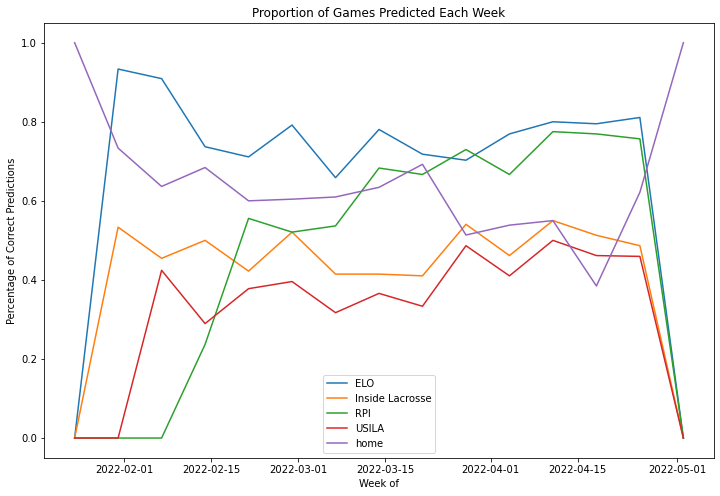

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Proportion of Games Predicted Each Week')
ax.set_ylabel('Percentage of Correct Predictions')
ax.set_xlabel('Week of')

ax.plot(df_weekly_results[['elo', 'ilax', 'rpi', 'usila', 'home']])
ax.legend(['ELO', 'Inside Lacrosse', 'RPI', 'USILA', 'home'])

In [103]:
get_rpi('Jacksonville', '5-4-2022')

0.5562847134550432